Project Goals


To analyze distribution of bus stops in Lahore in relation to Population distribution. And to identify underserved areas.




In [49]:
import matplotlib.pyplot as plt
import contextily as cx
import geopandas as gpd
import osmnx as ox
import warnings
import pandas as pd
import rasterio
import numpy as np
from rasterio.mask import mask
from shapely.geometry import mapping
warnings.filterwarnings("ignore")


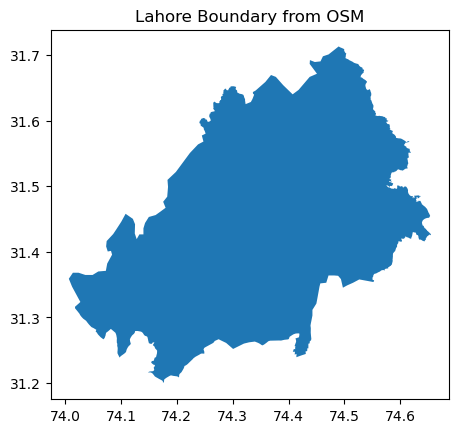

In [3]:

# Get Lahore boundary
place_name = "Lahore district"
lahore_boundary = ox.geocode_to_gdf(place_name)

# Plot the boundary
lahore_boundary.plot()
plt.title("Lahore Boundary from OSM")
plt.show()


In [5]:
def os_plotting(gdf, title):
    """
    Function to plot a GeoDataFrame with a basemap.
    """    
    # Plot bus stops using the OpenStreetMap basemap
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot bus stops in red on the map
    gdf.plot(ax=ax, marker='o', color='red', markersize=5)

    # Add OpenStreetMap basemap using Contextily
    cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

    # Title and show the plot
    plt.title(title)
    plt.show()

In [16]:

# Extract bus stops within the Lahore boundary
bus_stops = ox.features_from_place(place_name, tags={'highway':"bus_stop", 'public_transport':True})

/home/murtaza/anaconda3/envs/spatial_ds/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/murtaza/anaconda3/envs/spatial_ds/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/murtaza/anaconda3/envs/spatial_ds/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/murtaza/anaconda3/envs/spatial_ds/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  s

In [17]:
len(bus_stops)


217

In [18]:
bus_stops.columns

Index(['name', 'name:en', 'name:hi', 'name:pnb', 'name:ur', 'operator',
       'public_transport', 'railway', 'train', 'wikidata', 'wikipedia:ur',
       'geometry', 'highway', 'amenity', 'name:es', 'bus', 'network',
       'wikipedia', 'alt_name', 'alt_name:ur', 'shelter', 'departures_board',
       'route_ref', 'ref', 'subway', 'name:ar', 'name:be', 'name:de',
       'name:fa', 'name:pa', 'name:ru', 'name:sd', 'name:uk', 'name:zh',
       'station', 'level', 'description', 'description:zh', 'addr:city',
       'addr:country', 'addr:street', 'alt_name:en', 'wikipedia:en', 'nodes',
       'building', 'area', 'layer', 'ele', 'location', 'operator:ur'],
      dtype='object')

Data Cleaning

Removing null and dropping duplicates

In [19]:
bus_stops = bus_stops[bus_stops.geometry.notnull()]
bus_stops = bus_stops.drop_duplicates(subset='geometry')


/home/murtaza/anaconda3/envs/spatial_ds/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/murtaza/anaconda3/envs/spatial_ds/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/murtaza/anaconda3/envs/spatial_ds/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/murtaza/anaconda3/envs/spatial_ds/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use 

following shows there was no null or duplicate

In [20]:
len(bus_stops)

217

Keeping only point geometries, (there have been some polygons earlir that were with the tag of way, but we are interested in points for the sake of this project)

In [21]:
bus_stops = bus_stops[bus_stops.geometry.type == 'Point']

/home/murtaza/anaconda3/envs/spatial_ds/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/murtaza/anaconda3/envs/spatial_ds/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


Dropping the unused/irrelevant columns

In [22]:
columns_to_keep = [
    'name', 'operator', 'public_transport', 'highway',
    'amenity', 'bus', 'network', 'geometry'
]
bus_stops = bus_stops[columns_to_keep].copy()


/home/murtaza/anaconda3/envs/spatial_ds/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/murtaza/anaconda3/envs/spatial_ds/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/murtaza/anaconda3/envs/spatial_ds/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/murtaza/anaconda3/envs/spatial_ds/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  s

In [23]:
len(bus_stops)

191

/home/murtaza/anaconda3/envs/spatial_ds/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/home/murtaza/anaconda3/envs/spatial_ds/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/murtaza/anaconda3/envs/spatial_ds/lib/python3.10/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/home/murtaza/anaconda3/envs/spatial_ds/lib/python3.10/site-packages/geopandas/geoseries.py:221: DeprecationWarning: Passing a SingleBlockManager to GeoSeries is deprecated and will raise in a future version. Use p

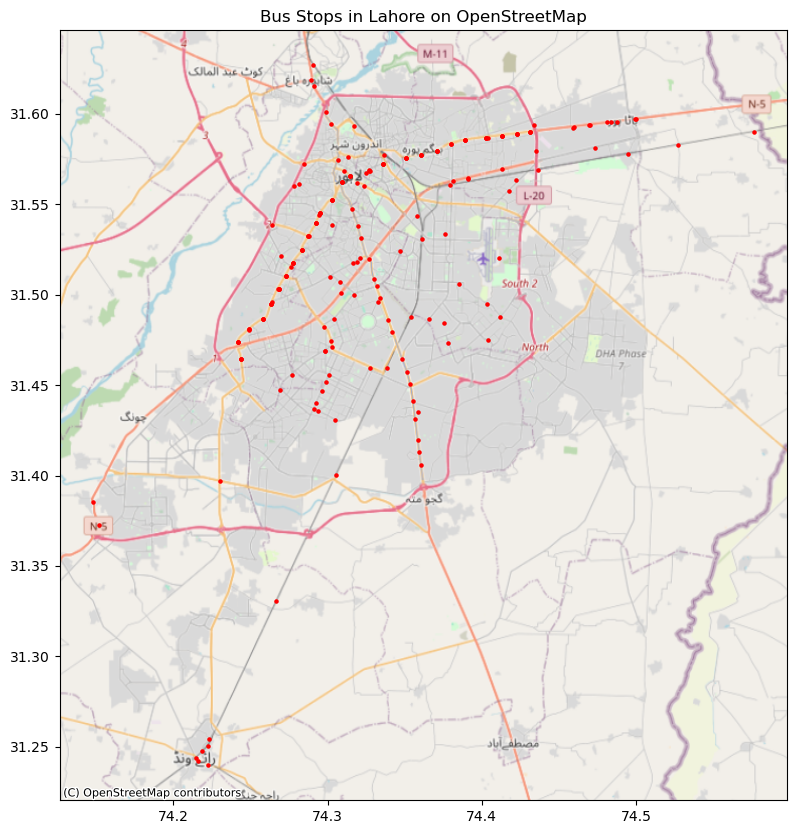

In [25]:
os_plotting(bus_stops, "Bus Stops in Lahore on OpenStreetMap")

Getting Lahore'population density data from Pakistan's population density (source: World POP)

In [65]:

pakistan_pop = rasterio.open("pak_ppp_2020.tif")

# Clip the raster
out_image, out_transform = mask(pakistan_pop,  lahore_boundary.geometry, crop=True)
out_meta = pakistan_pop.meta.copy()

# Mask no-data values
pop_lahore = np.ma.masked_equal(out_image[0], -99999.0)


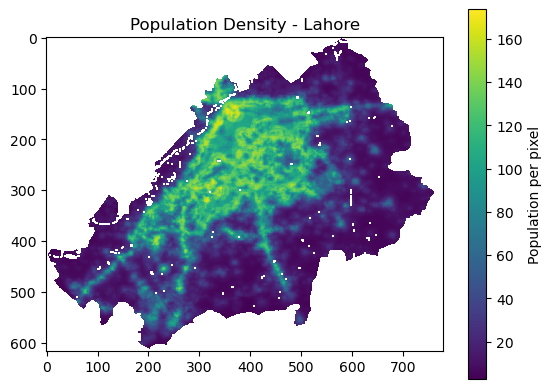

In [66]:

plt.imshow(pop_lahore, cmap='viridis')
plt.title("Population Density - Lahore")
plt.colorbar(label='Population per pixel')
plt.show()


Projecting CRS (for metric distances) in later analysis

In [62]:
bus_stops.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [93]:
bus_stops_utm = bus_stops.to_crs(epsg=32643)

bus_stops_utm.crs


<Projected CRS: EPSG:32643>
Name: WGS 84 / UTM zone 43N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 72°E and 78°E, northern hemisphere between equator and 84°N, onshore and offshore. China. India. Kazakhstan. Kyrgyzstan. Maldives. Pakistan. Russian Federation. Tajikistan.
- bounds: (72.0, 0.0, 78.0, 84.0)
Coordinate Operation:
- name: UTM zone 43N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [94]:
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import array_bounds

# Define source and target CRS
src_crs = pakistan_pop.crs
dst_crs = 'EPSG:32643'

# Get shape
height, width = pop_lahore.shape

# Compute bounds manually
bounds = array_bounds(height, width, out_transform)

# Calculate new transform and dimensions
dst_transform, dst_width, dst_height = calculate_default_transform(
    src_crs, dst_crs, width, height, *bounds
)

# Prepare an empty array
pop_lahore_reprojected = np.empty((dst_height, dst_width), dtype=np.float32)

# Perform reprojection
reproject(
    source=pop_lahore.filled(-99999.0),
    destination=pop_lahore_reprojected,
    src_transform=out_transform,
    src_crs=src_crs,
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    resampling=Resampling.nearest
)

# Mask again
pop_lahore_utm = np.ma.masked_equal(pop_lahore_reprojected, -99999.0)
pop_lahore_utm_transform = dst_transform


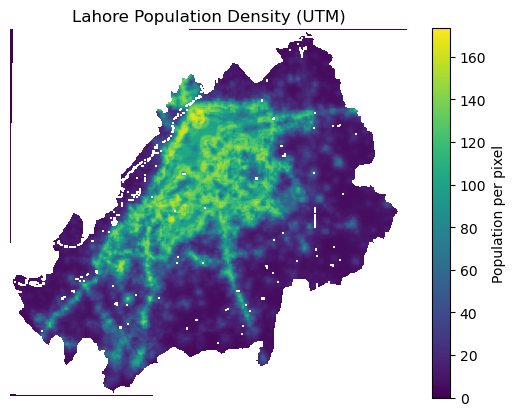

In [95]:
plt.imshow(pop_lahore_utm, cmap='viridis')
plt.title("Lahore Population Density (UTM)")
plt.colorbar(label='Population per pixel')
plt.axis('off')
plt.show()


Now we have wgs84 and utm reporjected datasets, we will move ahead with analysis part 

### Analysis and Visualizations

1. Bus stops overlayed on Population density

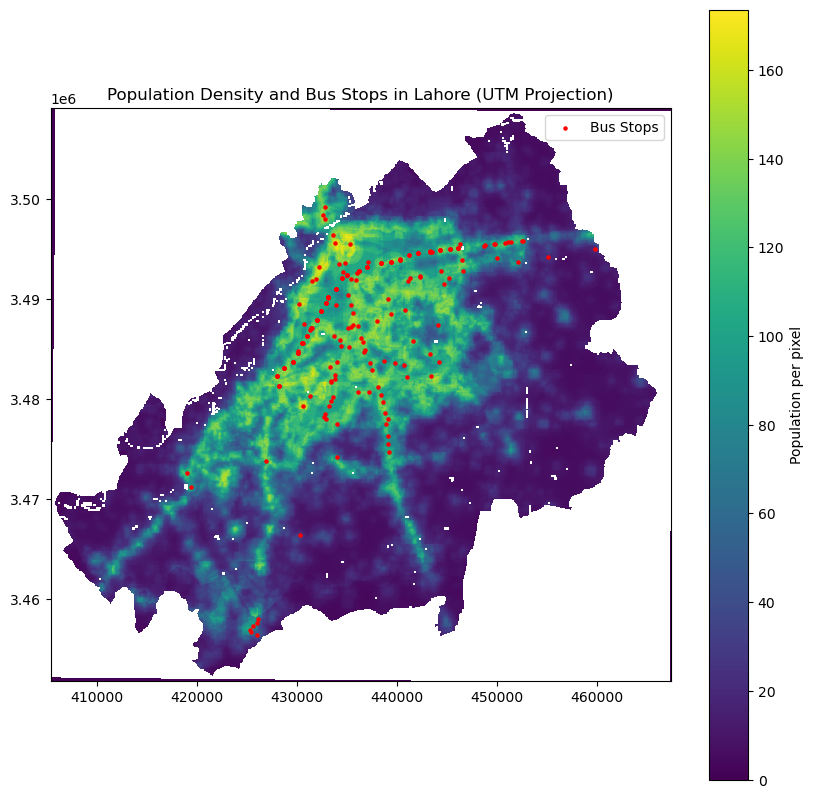

In [96]:
import matplotlib.pyplot as plt
from rasterio.plot import show
import geopandas as gpd

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the projected population raster
pop_show = ax.imshow(pop_lahore_utm, 
                     cmap='viridis', 
                     extent=[
                         pop_lahore_utm_transform[2], 
                         pop_lahore_utm_transform[2] + pop_lahore_utm.shape[1] * pop_lahore_utm_transform[0],
                         pop_lahore_utm_transform[5] + pop_lahore_utm.shape[0] * pop_lahore_utm_transform[4],
                         pop_lahore_utm_transform[5]
                     ],
                     origin='upper')

plt.colorbar(pop_show, ax=ax, label="Population per pixel")

# Plot bus stops (make sure this is reprojected to UTM 32643)
bus_stops_utm.plot(ax=ax, markersize=5, color='red', label='Bus Stops')

ax.set_title("Population Density and Bus Stops in Lahore (UTM Projection)")
ax.legend()
plt.show()


2. Estimating the population served at each bus stop

In [101]:
from rasterstats import point_query

# Perform the query
bus_stops_utm['pop_value'] = point_query(
    bus_stops_utm,                          # GeoDataFrame with bus stops (projected to UTM)
    pop_lahore_utm,                     # Masked array of raster data
    affine=pop_lahore_utm_transform,   # Transform object from raster reprojection
    nodata=-99999.0,                   # No-data value from original raster
    interpolate='nearest'              # Sampling method
)

# Preview the updated data
bus_stops_utm[['name', 'pop_value']].head()

name   pop_value
element_type osmid                                 
node         99902837             واہگہ   22.226175
             272338792              NaN  126.099709
             303060251  Comsats-BusStop  128.072205
             526681498    4 Number Gate  104.612411
             533745212              NaN  120.463440

In [141]:
from rasterstats import zonal_stats

# Create a 500m buffer around each bus stop
bus_stops_utm['geometry'] = bus_stops_utm.buffer(500)

# Calculate mean population within each buffer
pop_stats = zonal_stats(
    bus_stops_utm,
    pop_lahore_utm,
    affine=pop_lahore_utm_transform,
    nodata=-99999.0,
    stats=['mean', 'sum', 'count'],
    geojson_out=False
)

# Assign back to GeoDataFrame
bus_stops_utm['pop_mean'] = [stat['mean'] for stat in pop_stats]
bus_stops_utm['pop_sum'] = [stat['sum'] for stat in pop_stats]


In [142]:
bus_stops_utm[['name', 'pop_mean', 'pop_sum']].head()

name    pop_mean       pop_sum
element_type osmid                                               
node         99902837             واہگہ   24.884557   2587.993896
             272338792              NaN  115.557324  12711.305664
             303060251  Comsats-BusStop  125.369001  14041.328125
             526681498    4 Number Gate  107.653914  11518.968750
             533745212              NaN  115.221484  12674.363281

Summary Statistics:
 count    191.000000
mean     116.129302
std       21.438375
min       22.226175
25%      104.390480
50%      119.438934
75%      128.570625
max      168.038239
Name: pop_value, dtype: float64


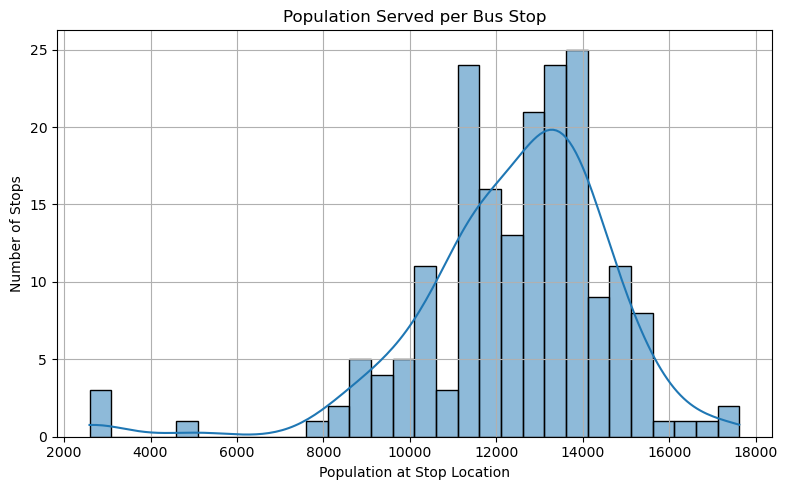

In [143]:
import seaborn as sns

# Drop missing or masked population values (if any)
valid_stops = bus_stops_utm.dropna(subset=['pop_value'])

# Descriptive statistics
summary_stats = valid_stops['pop_value'].describe()
print("Summary Statistics:\n", summary_stats)

# Histogram
plt.figure(figsize=(8, 5))
sns.histplot(valid_stops['pop_sum'], bins=30, kde=True)
plt.title('Population Served per Bus Stop')
plt.xlabel('Population at Stop Location')
plt.ylabel('Number of Stops')
plt.grid(True)
plt.tight_layout()
plt.show()


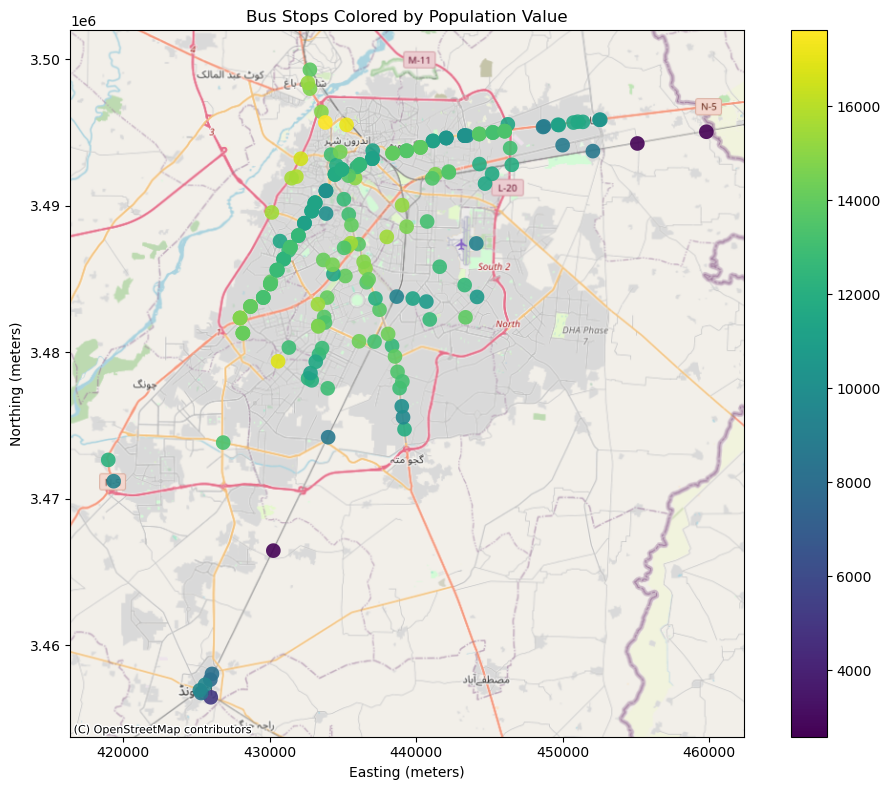

In [144]:

# Plot with contextily basemap
fig, ax = plt.subplots(figsize=(10, 8))

# Plot bus stops colored by population value
bus_stops_utm.plot(ax=ax, column='pop_sum', cmap='viridis', markersize=30, legend=True, alpha=0.9)

# Add basemap (web mercator projection)
cx.add_basemap(ax, crs=bus_stops_utm.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

# Set axis labels and layout
ax.set_title('Bus Stops Colored by Population Value')
ax.set_xlabel('Easting (meters)')
ax.set_ylabel('Northing (meters)')
plt.tight_layout()
plt.show()


### Nearest Neighbor Analysis

3. Nearest Neighbor Distance (NND) Analysis
Nearest Neighbor Distance (NND) measures the distance from each point (here: a bus stop) to its closest other point (i.e., the closest other bus stop). 

In [ ]:
from scipy.spatial import cKDTree

# Extract coordinates from projected GeoDataFrame
coords = np.array(list(bus_stops_utm.geometry.apply(lambda geom: (geom.x, geom.y))))

# Build KDTree for efficient spatial querying
tree = cKDTree(coords)

# Query nearest neighbor distance for each point (excluding self by k=2)
distances, _ = tree.query(coords, k=2)
nnd = distances[:, 1]  # the second nearest is the true nearest neighbor

# Add to GeoDataFrame
bus_stops_utm["nearest_nnd"] = nnd

# Display basic stats
mean_nnd = np.mean(nnd)
median_nnd = np.median(nnd)

print(f"Mean NND: {mean_nnd:.2f} meters")
print(f"Median NND: {median_nnd:.2f} meters")


Mean NND: 543.00 meters
Median NND: 254.48 meters


 4. Clark & Evans R-statistic for spatial randomness
 The R-statistic is used to test for spatial randomness of point patterns. 

In [111]:
from shapely.geometry import box

# Get bounds of the study area
bounds = bus_stops_utm.total_bounds  # [minx, miny, maxx, maxy]
area = (bounds[2] - bounds[0]) * (bounds[3] - bounds[1])
n_points = len(bus_stops_utm)

# Expected Mean Distance for CSR
expected_mean_nnd = 0.5 / np.sqrt(n_points / area)

# R-statistic
R = mean_nnd / expected_mean_nnd

print(f"Expected Mean NND (CSR - if random distribution): {expected_mean_nnd:.2f}")
print(f"R Statistic: {R:.3f}")

if R < 1:
    print("→ Pattern is clustered")
elif R > 1:
    print("→ Pattern is dispersed")
else:
    print("→ Pattern is random")


Expected Mean NND (CSR - if random distribution): 1513.96
R Statistic: 0.359
→ Pattern is clustered


**Observations**

We calculated the Nearest Neighbor Distances (NND) among all bus stops in Lahore. The observed mean NND is 543 meters and the median is approximately 254 meters, indicating that many bus stops are located quite close to each other.

To assess the spatial distribution pattern, we computed the Clark and Evans R-statistic, which compares the observed mean NND to the expected value under a random distribution (CSR). The resulting R-value of 0.359 suggests a strong clustering tendency among the bus stops, implying that they are strategically grouped in specific high-demand regions rather than being evenly or randomly distributed.


### Spatial Autocorrelation
**Moran's I**

In [145]:
from esda.moran import Moran
from libpysal.weights import DistanceBand

# Create spatial weights based on distance threshold (e.g., 1000 meters)
w = DistanceBand.from_dataframe(bus_stops_utm, threshold=1000, silence_warnings=True)
# Extract the population values as a numpy array
pop_values = bus_stops_utm['pop_sum'].values

# Compute Moran's I
moran = Moran(pop_values, w)

# Print the results
print(f"Moran's I: {moran.I:.4f}")
print(f"p-value: {moran.p_sim:.4f}")

# Interpretation
if moran.p_sim < 0.05:
    if moran.I > 0:
        print("→ Significant positive spatial autocorrelation: similar values cluster together.")
    elif moran.I < 0:
        print("→ Significant negative spatial autocorrelation: dissimilar values cluster together.")
    else:
        print("→ No spatial pattern detected.")
else:
    print("→ No statistically significant spatial autocorrelation.")


Moran's I: 0.4918
p-value: 0.0010
→ Significant positive spatial autocorrelation: similar values cluster together.


**Observation**

We computed Moran’s I to assess the spatial autocorrelation of population values around bus stops in Lahore. Using a 1000-meter threshold for neighborhood definition, we obtained a Moran's I value of 0.49 with a p-value of 0.001. This indicates a statistically significant and moderately strong positive spatial autocorrelation — bus stops with similar surrounding population levels tend to cluster spatially. In other words, densely populated areas are served by groups of bus stops that are themselves in proximity, suggesting a spatially structured pattern in transit service distribution.


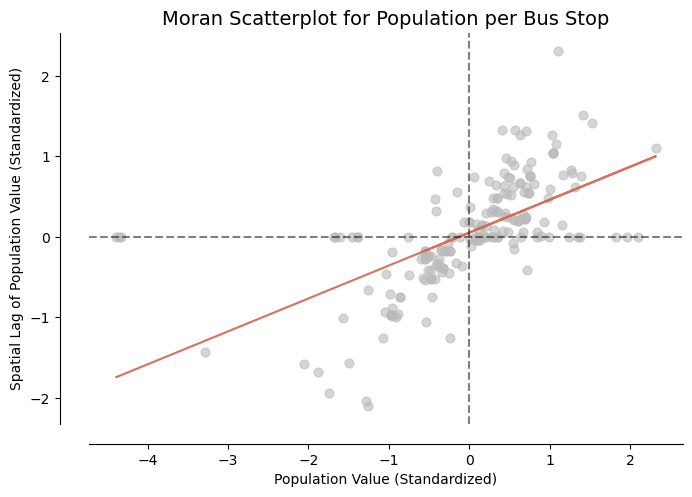

In [146]:
from splot.esda import moran_scatterplot

# Plot Moran scatterplot
fig, ax = moran_scatterplot(moran, aspect_equal=True)
ax.set_title("Moran Scatterplot for Population per Bus Stop", fontsize=14)
ax.set_xlabel("Population Value (Standardized)")
ax.set_ylabel("Spatial Lag of Population Value (Standardized)")
plt.tight_layout()
plt.show()


The Moran scatterplot shows a clear positive trend with most points clustered along the upward-sloping line, particularly in the upper right quadrant. This indicates that bus stops with high population values tend to be near other bus stops with similarly high values. The slope of approximately 0.5 reinforces the presence of moderate to strong positive spatial autocorrelation, consistent with the earlier Moran’s I value of 0.45.

**Gini Index**

Gini Coefficient: 0.0938


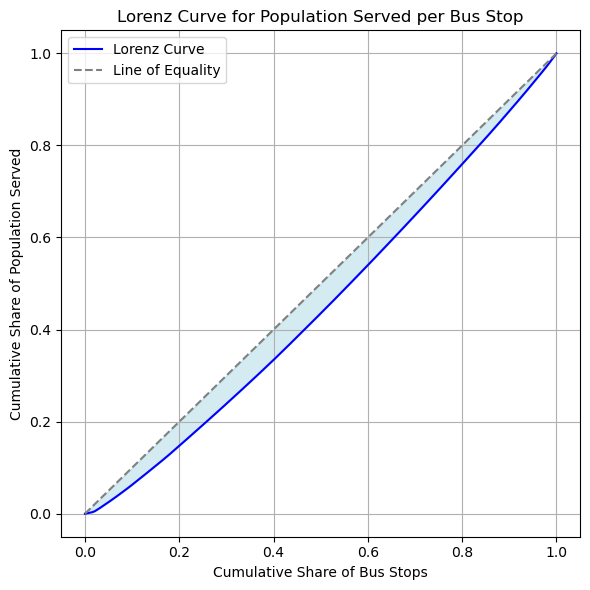

In [148]:
import numpy as np
import matplotlib.pyplot as plt

# Extract population values served per bus stop
pop_values = bus_stops_utm['pop_sum'].values

# Function to compute Gini coefficient
def gini(array):
    """Compute Gini coefficient of an array."""
    array = np.sort(array)
    n = array.size
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * array)) / (n * np.sum(array)) - (n + 1) / n

# Compute Gini
gini_value = gini(pop_values)
print(f"Gini Coefficient: {gini_value:.4f}")

# Plot Lorenz Curve
fig, ax = plt.subplots(figsize=(6, 6))
cum_pop = np.cumsum(np.sort(pop_values)) / np.sum(pop_values)
cum_pop = np.insert(cum_pop, 0, 0)  # Include origin
x_vals = np.linspace(0.0, 1.0, len(cum_pop))

ax.plot(x_vals, cum_pop, label="Lorenz Curve", color="blue")
ax.plot([0, 1], [0, 1], linestyle="--", color="grey", label="Line of Equality")
ax.fill_between(x_vals, cum_pop, x_vals, color="lightblue", alpha=0.5)

ax.set_title("Lorenz Curve for Population Served per Bus Stop")
ax.set_xlabel("Cumulative Share of Bus Stops")
ax.set_ylabel("Cumulative Share of Population Served")
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Observation**

The Lorenz curve lies close to the line of equality, and the Gini Coefficient is low (0.0938), indicating that the distribution of population served per bus stop is fairly equitable. This suggests that no bus stops are serving disproportionately large populations — the accessibility is reasonably balanced across the city.

### Underserved Areas Indentification

In [ ]:
from scipy.ndimage import distance_transform_edt
from rasterio.features import rasterize

# Step 3.1: Create an empty binary raster of bus stop locations
# Create a transform for indexing (same shape as pop_lahore_utm)
shape = pop_lahore_utm.shape
bus_stop_mask = rasterize(
    [(geom, 1) for geom in bus_stops_utm.geometry],
    out_shape=shape,
    transform=pop_lahore_utm_transform,
    fill=0,
    dtype='uint8'
)

# Step 3.2: Calculate Euclidean distance from each cell to the nearest bus stop
# Invert mask for distance_transform_edt (bus stops = False, rest = True)
distance = distance_transform_edt(bus_stop_mask == 0, sampling=[pop_lahore_utm_transform[4], pop_lahore_utm_transform[0]])


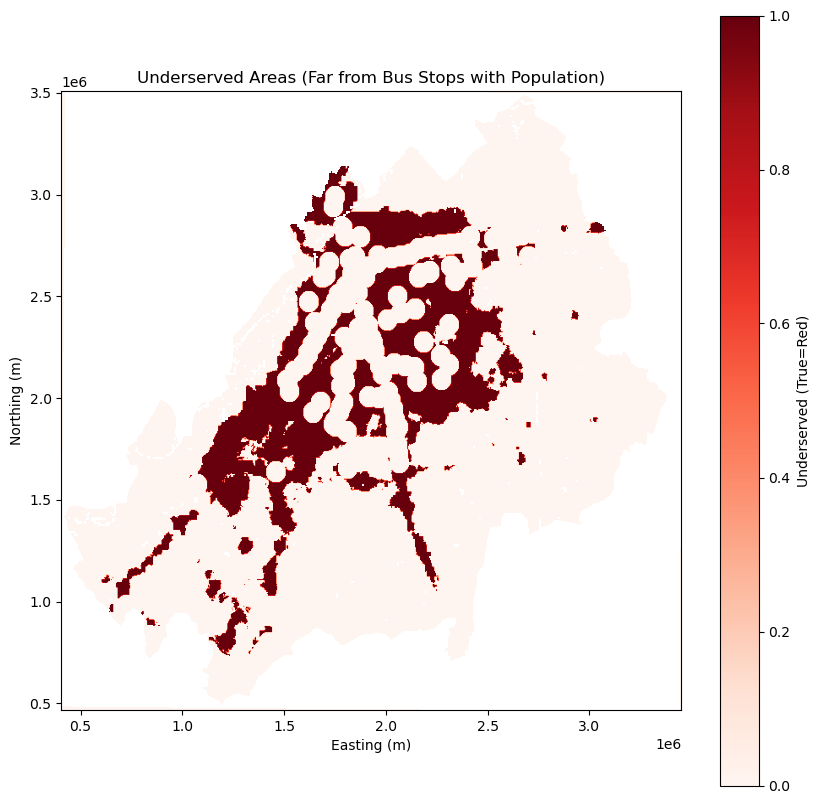

In [149]:
import matplotlib.pyplot as plt

# Step 4.1: Define underserved threshold (e.g., 500 meters)
distance_threshold = 1000  # in meters
pop_threshold = 60        # can tweak this as needed

# Step 4.2: Create mask for underserved areas
underserved_mask = (distance > distance_threshold) & (pop_lahore_utm > pop_threshold)

# Step 4.3: Plot
plt.figure(figsize=(10, 10))
plt.imshow(underserved_mask, cmap='Reds', extent=rasterio.transform.array_bounds(*pop_lahore_utm.shape, pop_lahore_utm_transform))
plt.title("Underserved Areas (Far from Bus Stops with Population)")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.grid(False)
plt.colorbar(label='Underserved (True=Red)')
plt.show()
